In [94]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import pandas as pd
import numpy as np
import csv
import re
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from utils import MultiHotEncoder, load_model, save_model
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
    

# 1. Analizando el objetivo del proyecto

El challenge Recsys 2022 tiene como objetivo predecir la probabilidad de que un usuario compre uno de los productos presentes en una lista preseleccionada. Para ello, se aportan 1 millon de sesiones que ilustran el recorrido de cada una a través de los diferentes artículos y, en última instancia, el producto adquirido.

El total de artículos presentes en el dataset <code>item_features.csv</code> asciende a 23.691 (aunque en el dataset <code>train_sessions.csv</code> sólo se han visualizado 23.496), de los cuales, sólo 4.990 son candidatos a la predicción.

En vista de la métrica de evaluación empleada en el challenge se establece que el objetivo de este proyeto es, dada una sesión, ordenar de mayor a menos los 100 artículos candidatos con mayor probabilidad de ser adquiridos al final de la sesión.

## 1.1. Pregunta interesante que podemos responder con datos

### **¿Cuáles son los 100 productos candidatos con mayor probabilidad de ser adquiridos en cada sesión en función de los productos visitados y las características de estos?**

# 2. Adquisición de datos

Debido a la magnitud del problema y la limitación computacional de los recursos disponibles durante la ejecución de este challenge, se ha decidido limitar las instancias disponibles en el dataset a aquellas que tengan como producto adquirido un producto de la lista de candidatos. Esto es, todas aquellas instancias que tengan como artículo comprado uno que lo aparezca en el dataset <code>candidate_items.csv</code> serán eliminados del dataset de train.

Otro de los métodos que valoramos fue dar una predicción de los 23.691 artículos de <code>item_features.csv</code> y, para la evaluación, considerar únicamente los 4.990 de <code>candidate_items.csv</code>. Sin embargo, por limites de hardware de los equipos empleados en este challenge tuvimos que descartar esta opción.

**La lógica empleada, a sabiendas de ser incompleta, supone que todas aquellas sesiones que no acaben en un artículo candidato no aportan información al modelo de aprendizaje automático y pueden ser descartadad.**

In [26]:
# Dataset de items candidatos donde se incluyen los 4.990 items objetivo.
candidate_items = pd.read_csv('dressipi_recsys2022/candidate_items.csv', dtype=str)['item_id']

# Dataset de compras durante las sesiones filtrado por aquellas donde item_id se encuentre entre los items candidatos.
df_p = pd.read_csv('dressipi_recsys2022/train_purchases.csv', parse_dates=['date'], dtype={'item_id': str, 'session_id':int})
df_p = df_p[df_p['item_id'].isin(candidate_items)]
candidate_sessions = df_p['session_id']

# Dataset de sesiones filtrada por aquellas sesiones que acaban en la adquisición de un producto candidato.
df_s = pd.read_csv('dressipi_recsys2022/train_sessions.csv', parse_dates=['date'], dtype={'item_id': str, 'session_id':int})
df_s_o = df_s.copy()
df_s = df_s[df_s['session_id'].isin(candidate_sessions)]
print('Dataset original sin filtrar:')
print(df_s_o.shape)
print()
print('Dataset filtrado:')
print(df_s.shape)
del df_s_o


Dataset original sin filtrar:
(4743820, 3)

Dataset filtrado:
(2085385, 3)


Mediante la decisión tomada, reducimos el dataset de train de 4.743.820 instancias a **menos de la mitad**: 2.085.385 instancias.

In [21]:
items_viewed_by_session = df_s.groupby('session_id')['item_id'].unique()

In [22]:
# Comprobamos que los artículos presentes en el dataset de train so, efectivamente, los candidatos.
assert (items_viewed_by_session.index == df_p['session_id']).all()

In [70]:
# Dataset de características de producto
df_f = pd.read_csv('dressipi_recsys2022/item_features.csv', dtype='str')


# 3. Análisis de datos

## 3.1. Dataset <code>train_purchases.csv </code>

In [27]:
df_p.head()

,session_id,item_id,date
1,13,18626,2020-03-13 19:36:15.507
6,31,8345,2021-04-20 19:46:42.594
8,42,11784,2021-03-01 15:17:04.264
17,113,21107,2021-05-05 14:15:07.278
18,115,25976,2021-05-27 10:24:05.043


El dataset <code>train_purchases.csv </code> se organiza de forma que cada instancia es el producto comprado en una sesión, **item_id**, y la fecha y hora en que ese producto fue comprado, **date**.

In [29]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450153 entries, 1 to 999999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   session_id  450153 non-null  int32         
 1   item_id     450153 non-null  object        
 2   date        450153 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 12.0+ MB


In [32]:
print('Las sesiones se encuentran entre '+str(df_p.date.min())+' y '+str(df_p.date.max()))

Las sesiones se encuentran entre 2020-01-01 01:35:42.278000 y 2021-05-31 23:47:07.764000


In [67]:
print('El total de productos comprados es '+str(df_p['item_id'].nunique()))

El total de productos comprados es 4877


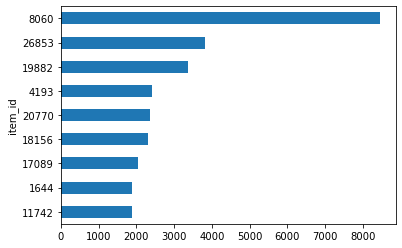

In [54]:
df_p_top_10 = df_p.groupby(by='item_id')['session_id'].count().sort_values(ascending=False)[0:9]
df_p_top_10.sort_values(ascending=True).plot(kind='barh')
del df_p_top_10

Some of the products have been sold over 8.000 times.

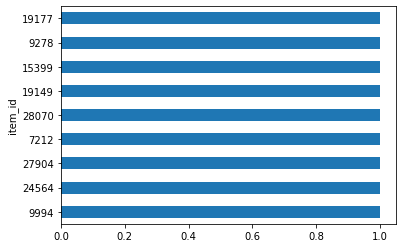

In [53]:
df_p_bottom_10 = df_p.groupby(by='item_id')['session_id'].count().sort_values()[0:9]
df_p_bottom_10.plot(kind='barh')
del df_p_bottom_10

While others have been sold just 1 time.

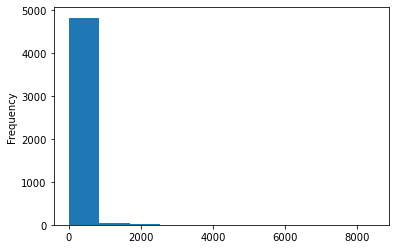

In [60]:
df_p_times_sold = df_p.groupby(by='item_id')['session_id'].count()
df_p_times_sold.plot(kind='hist')

In [61]:
print(df_p_times_sold.describe())
del df_p_times_sold

count    4877.00000
mean       92.30121
std       215.97481
min         1.00000
25%        20.00000
50%        46.00000
75%        92.00000
max      8451.00000
Name: session_id, dtype: float64


## 3.2. Dataset <code>train_sessions.csv</code>

In [62]:
df_s.head()

,session_id,item_id,date
2,13,15654,2020-03-13 19:35:27.136
36,31,25972,2021-04-20 19:38:03.816
37,31,16289,2021-04-20 19:39:17.092
38,31,2069,2021-04-20 19:40:21.952
39,31,27579,2021-04-20 19:43:43.813


El dataset <code>train_sessions.csv </code> se organiza de forma que cada instancia es un producto visto en una sesión, **item_id**, y la fecha y hora en que ese producto fue visto, **date**.

In [63]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085385 entries, 2 to 4743819
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   session_id  int32         
 1   item_id     object        
 2   date        datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 55.7+ MB


In [64]:
print('Las sesiones se encuentran entre '+str(df_s.date.min())+' y '+str(df_s.date.max()))

Las sesiones se encuentran entre 2020-01-01 01:21:33.200000 y 2021-05-31 23:43:33.865000


In [66]:
print('El total de productos vistos es '+str(df_s['item_id'].nunique()))

El total de productos vistos es 18604


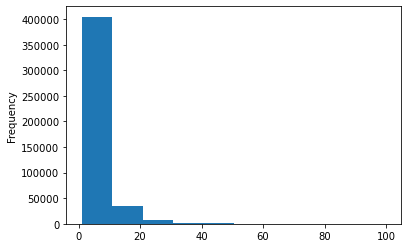

In [68]:
df_prod_vist = df_s.groupby(by='session_id')['item_id'].count()
df_prod_vist.plot(kind='hist')

In [69]:
print(df_prod_vist.describe())
del df_prod_vist

count    450153.000000
mean          4.632614
std           5.896939
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         100.000000
Name: item_id, dtype: float64


La media de productos vistos durante las sesiones es de 4,63 mientras que algunas sesiones llegan a 100 productos visualizados antes de hacer la compra. Estas sesiones con tantos productos visualizados son claramente outliers. **El 75% de las sesiones han visto 6 artículos o menos**.

## 3.3. Dataset <code>item_features.csv</code>

In [71]:
df_f.head()

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75


El dataset <code>item_features.csv </code> se organiza de forma que cada instancia representa una característica de un producto, **feature_category_id**, y el valor que esta toma, **feature_value_id** **item_id**. Cada producto (**item_id**) puede tener un número **n** de características valoradas.

In [74]:
df_f.groupby(by='item_id')['feature_category_id'].count().describe()

count    23691.000000
mean        19.912667
std          5.130942
min          2.000000
25%         17.000000
50%         20.000000
75%         24.000000
max         33.000000
Name: feature_category_id, dtype: float64

Los productos tienen una media de 19,91 características, con un mínimo de 2 y un máximo de 33.

In [76]:
df_f['feature_category_id'].describe()

count     471751
unique        73
top           47
freq       23691
Name: feature_category_id, dtype: object

Existen un total de 73 características distintas.

In [79]:
df_f['feature_value_id'].astype(int).describe()

count    471751.000000
mean        486.345578
std         258.865151
min           1.000000
25%         273.000000
50%         512.000000
75%         708.000000
max         905.000000
Name: feature_value_id, dtype: float64

Los valores de las características son tremendamente dispares, con mínimo de 1 y máximo de 905 y una desviación estándar de 258,86.

Analizado el dataset de <code>item_features.csv</code>, llegamos a la conclusión de que no podemos extraer demasiados insights de valor de este dataset. Incluso en la descripción del challenge se establece que una misma combinación variable - valor puede representar algo distinto en función del producto al que haga referencia.

La conclusión a la que llega este equipo es que la mejor forma de emplear este dataset será crear clústers K-Means que, de alguna forma, agrupen las 73 características y sus valores en una serie de clústers que simplifiquen su comprensión y posterior procesado. Este procesado se realizará en el apartado **4. Feature engineerin**.

# 4. Feature engineering

**Cabe remarcar que, a pesar de que este notebook incluya múltiples elementos de feature engineering, para el modelado final se ha optado por dejar todos estos elementos fuera del train. Esta decisión se ha tomado en base a las limitaciones establecidas al inicio de este notebook respecto al hardware necesario para procesar los datasets disponibles.**

## 4.1. Clusterizado K-Means de características de productos

Debido a la descripción del challenge aportada, tenemos que decidir si incluimos los valores que toman las características o no.

Según lo entendido por este equipo, la característica color (p.ej) es común a todos los artículos (p.ej: feature_category_id = 7). Sin embargo, el color rojo, representado en feature_value_id varía en función del tipo de artículo (p.ej, en camisetas toma el valor 108 y en pantalones el valor 210).

Realizaremos 3 pruebas distintas:
- Considerando únicamente la feature_category (**Opción 1**)
- Considerando la combinación feature_category y feature_value (**Opción 2**)

### 4.1.1. Opción 1

In [111]:
# Transformamos el dataset item_features a una serie cuyo índice es el item_id los valores de la lista serán las features que tienen estos artículos
features_by_item = df_f.groupby('item_id')['feature_category_id'].unique()

features_by_item.head()


item_id
10       [56, 15, 63, 12, 30, 61, 50, 69, 7, 72, 62, 68...
100      [56, 30, 61, 8, 7, 69, 26, 70, 25, 32, 57, 14,...
10000    [18, 3, 46, 5, 19, 73, 68, 63, 50, 69, 55, 61,...
10001    [12, 62, 4, 7, 34, 17, 46, 69, 73, 72, 68, 65,...
10002    [68, 72, 11, 7, 26, 19, 34, 59, 50, 61, 56, 73...
Name: feature_category_id, dtype: object

In [112]:
mlb_kmeans = MultiLabelBinarizer(sparse_output=False)
feature_by_item_mlb = mlb_kmeans.fit_transform(features_by_item)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


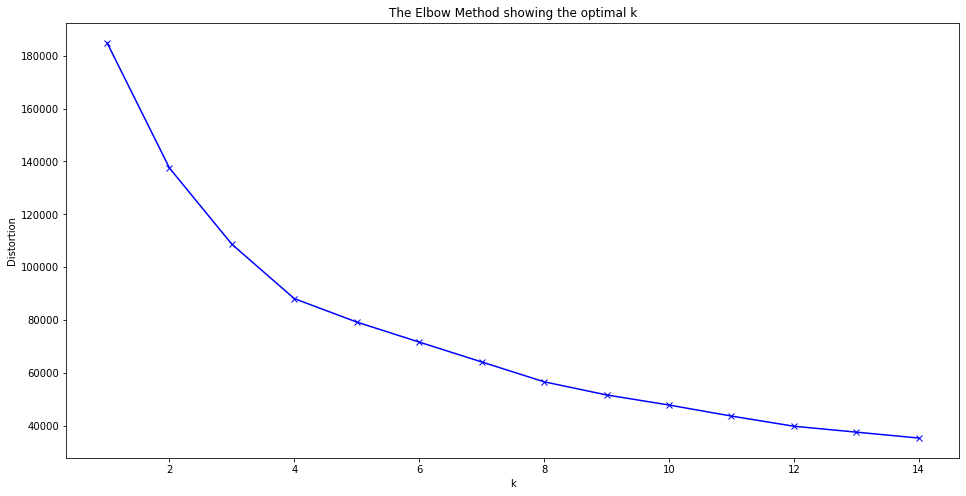

In [113]:
from concurrent.futures import ThreadPoolExecutor, as_completed 

kmeanmodels = dict()

K = range(1,15,1)

for k in K:
    print(k)
    kmeanmodels[k] = KMeans(n_clusters=k)
    kmeanmodels[k].fit(feature_by_item_mlb)

    distortions = [kmeanmodels[x].inertia_ for x in kmeanmodels]
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### 4.1.2. Opción 2

In [119]:
df_f_2=df_f.copy()
df_f_2.loc[:,'cat_and_value']=df_f_2['feature_category_id']+"-"+df_f_2['feature_value_id']

df_f_2.head()


,item_id,feature_category_id,feature_value_id,cat_and_value
0,2,56,365,56-365
1,2,62,801,62-801
2,2,68,351,68-351
3,2,33,802,33-802
4,2,72,75,72-75


In [121]:
features_and_values_by_item = df_f_2.groupby('item_id')['cat_and_value'].unique()

features_and_values_by_item.head()

item_id
10       [56-365, 15-451, 63-816, 12-410, 30-564, 61-70...
100      [56-365, 30-482, 61-706, 30-478, 8-323, 7-490,...
10000    [18-289, 3-793, 46-825, 5-605, 19-765, 73-544,...
10001    [12-699, 62-801, 4-618, 7-452, 34-275, 17-378,...
10002    [68-383, 72-712, 11-109, 7-798, 26-268, 19-765...
Name: cat_and_value, dtype: object

In [122]:
mlb_kmeans_2 = MultiLabelBinarizer(sparse_output=False)
features_and_values_by_item_mlb = mlb_kmeans.fit_transform(features_and_values_by_item)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


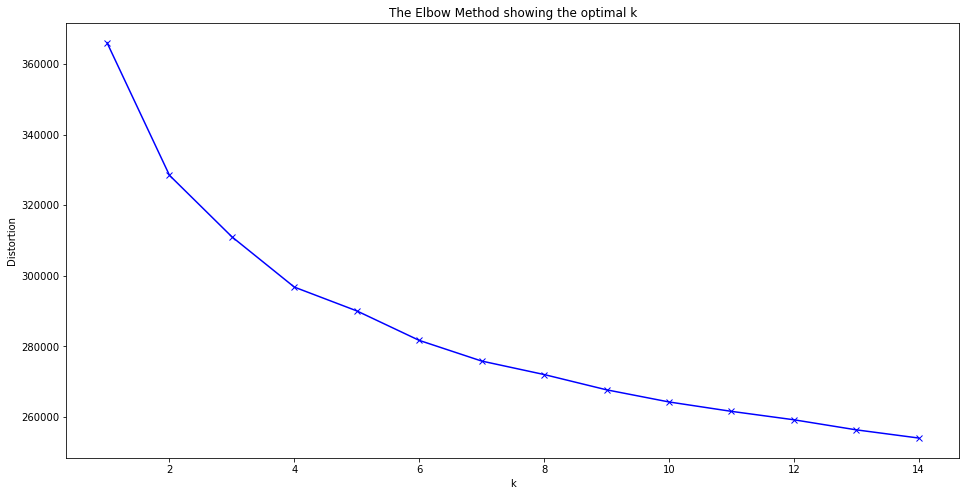

In [123]:
kmeanmodels2 = dict()

K = range(1,15,1)

for k in K:
    print(k)
    kmeanmodels2[k] = KMeans(n_clusters=k)
    kmeanmodels2[k].fit(features_and_values_by_item_mlb)

    distortions = [kmeanmodels2[x].inertia_ for x in kmeanmodels2]
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### 4.1.4. Conclusión

Al analizar los 2 clústers, vemos que todos ellos tienen un **K óptimo en 4**.

Debido a las limitaciones mencionadas anteriormente, elegimos la opción 1 por simplicidad de cálculo.

In [139]:
# Creamos un diccionario con los clústers de cada artículo para mapearlo con el dataset de sesiones.
n_clusters = 4
item_to_cluster = dict(zip(features_by_item.index, kmeanmodels[n_clusters].predict(feature_by_item_mlb)))

## 4.2 Otras variables de interés

### 4.2.1. Añadimos el total de veces que se ha visualizado cada item

In [140]:
df_s['cluster'] = df_s['item_id'].map(item_to_cluster)

clusters_viewed_by_session = df_s.groupby('session_id')['cluster'].unique()

In [141]:
assert (clusters_viewed_by_session.index==df_p['session_id']).all()

### 4.2.2 Añadimos cuál es el primer item y el último item visto en cada sesión.

In [146]:
last_seen = df_s.sort_values(['session_id', 'date'], ascending=[True, False]).drop_duplicates(subset='session_id').set_index('session_id')['item_id']
first_seen = df_s.sort_values(['session_id', 'date'], ascending=[True, True]).drop_duplicates(subset='session_id').set_index('session_id')['item_id']

### 4.2.3. Añadimos el total de productos vistos en cada sesión

In [143]:
prod_count=df_s.groupby('session_id')['item_id'].count().rename('prod_count')

### 4.2.4. Añadimos el total de duración de la sesión y el tiempo por producto

In [153]:
# Ordenamos la sesión por fecha
session_sorted = df_s.sort_values(by=['date'])

# Inicio de la sesión
begin_df = session_sorted.groupby('session_id')['date'].first().rename('start_date')

# Final de la sesión
end_df = session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Concatenamos los datasets
times_df=pd.concat([begin_df,end_df, prod_count],axis=1)

# Ajustamos el formato de fecha
times_df['start_date']=pd.to_datetime(times_df['start_date'])
times_df['end_date']=pd.to_datetime(times_df['end_date'])

# Tiempo total de sesión
times_df['time_diff']=(times_df.end_date-times_df.start_date).astype('timedelta64[s]')

# Tiempo total por producto
times_df['time_per_prod']=times_df['time_diff']/times_df['prod_count']

# Calculamos las diferencias de tiempo
times_df['time_diff']=(times_df.end_date-times_df.start_date).astype('timedelta64[s]')

### 4.2.5. Añadimos el momento del día en que comienza la sesión

In [154]:
mask=(times_df.start_date.dt.hour>=0) & (times_df.start_date.dt.hour<7)
times_df.loc[mask,'time_first_prod']='madrugada'
mask=(times_df.start_date.dt.hour>=7) & (times_df.start_date.dt.hour<12)
times_df.loc[mask,'time_first_prod']='día'
mask=(times_df.start_date.dt.hour>=12) & (times_df.start_date.dt.hour<18)
times_df.loc[mask,'time_first_prod']='tarde'
mask=(times_df.start_date.dt.hour>=18) & (times_df.start_date.dt.hour<24)
times_df.loc[mask,'time_first_prod']='noche'

### 4.2.6. Añadimos el total de veces que se ha visto cada clúster

In [160]:
df_clust_count = df_s.groupby(['session_id', 'cluster'])['session_id'].aggregate('count').unstack().fillna(0)

In [162]:
df_clust_count

cluster,0,1,2,3
session_id,,,,
13,0.0,0.0,1.0,0.0
31,0.0,8.0,0.0,0.0
42,0.0,2.0,2.0,0.0
113,0.0,4.0,2.0,0.0
115,0.0,0.0,0.0,8.0
...,...,...,...,...
4439954,0.0,1.0,0.0,0.0
4439986,0.0,0.0,6.0,0.0
4439990,0.0,8.0,2.0,1.0


## 4.3. Unir todo el dataset

In [170]:
# Add all data in sigle DF to feed the pipeline
all_data = df_p.set_index('session_id').copy()
all_data['items'] = items_viewed_by_session
all_data['clusters'] = clusters_viewed_by_session
all_data['last_seen'] = last_seen
all_data['first_seen'] = first_seen
all_data['prods_seen'] = prod_count
all_data['time_spent'] = times_df['time_diff']
all_data['time_per_prod'] = times_df['time_per_prod']
all_data = pd.concat([all_data, df_clust_count], axis = 1)

In [171]:
all_data.head()

,item_id,date,items,clusters,last_seen,first_seen,prods_seen,time_spent,time_per_prod,0,1,2,3
session_id,,,,,,,,,,,,,
13,18626,2020-03-13 19:36:15.507,[15654],[2],15654,15654,1,0.0,0.000,0.0,0.0,1.0,0.0
31,8345,2021-04-20 19:46:42.594,"[25972, 16289, 2069, 27579, 26457, 4230, 264]",[1],4230,25972,8,439.0,54.875,0.0,8.0,0.0,0.0
42,11784,2021-03-01 15:17:04.264,"[10395, 20523, 17472, 22492]","[2, 1]",17472,20523,4,120.0,30.000,0.0,2.0,2.0,0.0
113,21107,2021-05-05 14:15:07.278,"[2171, 17218, 15738, 19760, 21215, 6187]","[1, 2]",17218,6187,6,3300.0,550.000,0.0,4.0,2.0,0.0
115,25976,2021-05-27 10:24:05.043,"[16631, 19705, 15969, 10442]",[3],16631,19705,8,36.0,4.500,0.0,0.0,0.0,8.0


In [173]:
all_data_train = all_data[['item_id', 'date', 'items', 'clusters', 'last_seen', 'first_seen']]

## 4.4. Conclusión

Hemos mencionado en varias ocasiones las limitaciones de entrenar el modelo por el tamaño del dataset. De cara a facilitar esta tarea, finalmente el equipo decidió incluir únicamente las variables:
- item_id
- date
- items
- clusters
- last_seen
- first_seen

In [8]:
# Save data to read on demand and require less memory
save_model(all_data_train, 'data.pkl')

# 5. Modeling

De cara a decidir qué columna de productos utilizaremos (last_seen, first_seen o item_id) queremos entender la cantidad de espacio que vamos a ahorrar empleando una de las que no incluyen todos los productos:

In [20]:
print(f"Items by session: {df_s['item_id'].nunique()} features")
print(f"Clusters by session: {n_clusters} features")
print(f"First item by session: {all_data['last_seen'].nunique()} features")
print(f"Last item by session: {all_data['first_seen'].nunique()} features")

Items by session: 18604 features
Clusters by session: 4 features
First item by session: 15139 features
Last item by session: 15449 features


Emplearemos únicamente items_by_session y clusers de cara al training del modelo

## 5.1. Split en train y test

Debido a limitaciones de memoria, emplearemos únicamente el 50% de los datos para el training

In [2]:
all_data = load_model('data.pkl')
train_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(all_data, all_data['item_id'], random_state=42, train_size=train_size)


## 5.2. Construimos el pipeline con las transformaciones

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from utils import MultiHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier

Hemos dividido el pipeline en dos partes diferenciadas:
- Primero convertimos items_by_session y clusters en matrices multihot-sparse
- Se reduce su dimensionalidad vía TruncatedSVD

Finalmente se eligen 5.000 características ya que se mantiene el 90% de la información.

Esta transformación exigirá mucha memoria por lo que se almacenarán los resultados para liberar memoria de cara al train.

In [ ]:
# Número de componentes elegidos
svd_components = 5000

# Transformamos items_by_session y clusters_by_session en una matric multihot-sparse
column_transformer = ColumnTransformer([
    ('items_by_session', MultiHotEncoder(), ['items']), # ~18604
    ('clusters_by_session', MultiHotEncoder(), ['clusters']), # ~4
    ])
_x = column_transformer.fit_transform(X_train)
del X_train
save_model(column_transformer, 'column_transformer.pkl'); del column_transformer
column_transformer = load_model('column_transformer.pkl')

# El resultado se procesa con TruncateSVD para reducir la dimensionalidad
tsvd = TruncatedSVD(n_components=svd_components, random_state=42)
_x = tsvd.fit_transform(_x)
print(sum(tsvd.explained_variance_ratio_))
save_model(tsvd, 'tsvd.pkl'); del tsvd
tsvd = load_model('tsvd.pkl')
print(2)

all_transformations = Pipeline([('column_transformer', column_transformer), ('tsvd',tsvd)])
del column_transformer, tsvd

# Se guarda el modelo para liberar memoria
save_model(all_transformations, 'all_transformations.pkl')

save_model(_x, 'X_train_transformed.pkl')
save_model(all_transformations.transform(X_test, 'X_test_transformed.pkl'))

## 5.3. Train

Debido a las características del problema, elegimos entrenar un Random Forest y limitar el máximo de profundidad a 25 para adaptarse a las capacidades de computación de nuestros sistemas.

Aumentar la profundidad aumentaba exponencialmente las necesidades de computación.

Se han requerido 32Gb de RAM y 200GB de SWAP para el entrenamiento del modelo de profundidad 25.

Finalmente se elige el modelo de profundidad 3.

In [55]:
rfc = RandomForestClassifier(max_depth=3)
for i in list(range(3,14, 2)) + [25]:
    rfc.fit(load_model('X_train_transformed.pkl'), y_train)
    

### 5.3.1. Tamaño del modelo en función de n_samples

In [ ]:
import os
depths = []
sizes = []
for f in os.listdir('.'):
    a = re.search(r'rfc_(\d*)\.pkl', f)
    if a:
        depths.append(int(a.group(1)))
        sizes.append(os.path.getsize(f))

plt.scatter(depths, sizes, linewidths=1, )
plt.xlabel('max_depth')
plt.ylabel('Size in 10Gb')
plt.title('Model size by max_depth')
plt.show()


## 5.4. Evaluación del modelo

Debido a la particular métrica de evaluación empleada en el challenge RecSys, que considera las 100 mejores predicciones, se ha definido la siguiente función:

In [1]:
def capstone_score(model, x_test, y_real, n=100):
    _classes = model.classes_
    if hasattr(model, 'predict_proba'):
        rank_func = model.predict_proba
    elif hasattr(model, 'decision_function'):
        rank_func = model.decision_function
    y_pred = _classes[np.flip(rank_func(x_test).argsort())]
    scores = []
    for _y_true, _y_pred in zip(y_real, y_pred):
        index=np.where(_y_pred[:n] == _y_true)[0]
        if not index:
            pred_score = 0
        else:
            pred_score = 1/index[0]
        scores.append(pred_score)
    return np.mean(scores)

In [ ]:
a, b = resample(load_model('X_test_transformed.pkl'), y_test, n_samples=y_test.shape[0]//2, random_state=42)
capstone_score(load_model('rfc_5.pkl'), a,b)

In [ ]:
a, b = resample(load_model('X_test_transformed.pkl'), y_test, n_samples=y_test.shape[0]//5, random_state=42)

for i in list(range(3,14, 2)) + [25]:
    print(f'{i}: ', capstone_score(load_model(f'rfc_{i}.pkl'), a, b))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   21.6s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   53.0s finished


3:  0.023855667485798922


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   25.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:  1.0min finished


5:  0.02324894387677719


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   24.5s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   59.2s finished


7:  0.022502217429844144


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   24.4s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   59.7s finished


9:  0.021605093793532166


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   30.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:  1.2min finished


11:  0.02081202086998794


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   30.9s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:  1.2min finished


13:  0.019930774654749173


Oservamos que una mayor profundidad no ayuda a obtener una mejor score, por lo que nos decidimos por una profundidad máxima de 3.

## 5.5. Comparación con otros modelos lineales

Debido a las múltiples decisiones que hemos tomado a lo largo de este proyecto, no existe forma de comparar este resultado con los obtenidos en el challenge RecSys. Por ello, hemos decidido realizar otra predicción con un modelo lineal más simple y comparar los resultados.

En este caso particular, y considerando max_depth = 3, el resultado obtenido es **0.02385566748579892** frente a **0.002111074682055869** obtenido con el modelo lineal, suponiendo una mejora de aproximadamente 11 veces.

Teniendo en cuenta que existen 4.990 artículos objetivo, y asignarlos aleatoriamente tendría una probabilidad de éxito de 0.0002 (sin considerar el método de evaluación del caso), consideramos que el modelo definido mejora sustancialmente el modelo random y modelos más simples como el lineal.

In [14]:
del _x_train, _x_test, _y_train, _y_test 
from sklearn.linear_model import Perceptron
per = Perceptron()
train_size = 1000
_x_train, _x_test, _y_train, _y_test = train_test_split(load_model('X_train_transformed.pkl'), y_train, train_size=train_size)
while _x_test.shape[0] > 1000:
    print(_x_test.shape[0])
    per.partial_fit(_x_train, _y_train,classes=y_train)
    _x_train, _x_test, _y_train, _y_test = train_test_split(_x_test, _y_test, train_size=train_size)
per.partial_fit(_x_test, _y_test)

224076
223076
222076
221076
220076
219076
218076
217076
216076
215076
214076
213076
212076
211076
210076
209076
208076
207076
206076
205076
204076
203076
202076
201076
200076
199076
198076
197076
196076
195076
194076
193076
192076
191076
190076
189076
188076
187076
186076
185076
184076
183076
182076
181076
180076
179076
178076
177076
176076
175076
174076
173076
172076
171076
170076
169076
168076
167076
166076
165076
164076
163076
162076
161076
160076
159076
158076
157076
156076
155076
154076
153076
152076
151076
150076
149076
148076
147076
146076
145076
144076
143076
142076
141076
140076
139076
138076
137076
136076
135076
134076
133076
132076
131076
130076
129076
128076
127076
126076
125076
124076
123076
122076
121076
120076
119076
118076
117076
116076
115076
114076
113076
112076
111076
110076
109076
108076
107076
106076
105076
104076
103076
102076
101076
100076
99076
98076
97076
96076
95076
94076
93076
92076
91076
90076
89076
88076
87076
86076
85076
84076
83076
82076
81076
80076
79076

Perceptron()

In [29]:
a, b = resample(load_model('X_test_transformed.pkl'), y_test, n_samples=y_test.shape[0]//2, random_state=42)
capstone_score(per, a,b)


0.002111074682055869